# This project presents an example of how to perform an exploratory data analysis. WhatsApp was chosen as a data source in order to understand my behavior and that of my friends. This project can be reproduced by anyone using their own data from whatsApp. For obvious reasons, the data used to perform the analysis will not be provided.


based on the project proposed at https://blog.jovian.ai/whatsapp-message-exploratory-data-analysis-eda-538560ee1c99.





# To carry out the exploratory analysis, it is necessary to know what questions we want to answer through the data. Therefore, the following questions are answered in this analysis:


Question 1: What is the period in which the data was collected?

Question 2: Which users have the most Chat/messages in the group?

Question 3: Which emojis use the most in the group?

Question 4: Which emoji is most used by each user?

Question 5: What are the top words used in the conversation?

Question 6: What are the top words used by each user?

Question 7: What is the most active time of messages in group throughout the day?

Question 8: What is the most active time for each user?

Question 9: What is the most active day of messages in group throughout the week?

Question 10: What is the most active day of each user in the group?

Question 11: What is the most active month of messages in group?

Question 12: What is the most active month of each user in the group?



# Follow is imported all the necessary libraries for this project.

In [1]:
import plotly.express as px
import os
import pandas as pd
import re
import datetime as time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import emoji
import re
from collections import Counter
from wordcloud import WordCloud
import nltk


# Undertand the data

Data is divided into two columns. In column 0 it shows a date that message was sent. Column 1 presents the time, sender and a sent message. It is possible to notice through the info function that there is missing data in column 1.


In [2]:
data = pd.read_fwf('chat.txt', header= None)
data.head()

0                                                  1
0  3/23/21,  11:37 PM - Thales: Tava pagando mais em outras...
1  3/23/21,            11:37 PM - Galo: Kkkkkkkkkkk tais doido
2  3/23/21,                      11:37 PM - Thales: Imoral viu
3  3/23/21,           11:37 PM - Thales: Fortaleza tomou nas 7
4  3/23/21,  11:37 PM - Thales: Doido eh quem aposta na cop...

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40779 entries, 0 to 40778
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       40779 non-null  object
 1   1       40650 non-null  object
dtypes: object(2)
memory usage: 637.3+ KB


# Data cleaning.

The purpose of the following function is to transport the data contained in the chat.txt file to a pandas dataframe. For that, we created a dataframe with three columns. The timestamp column presents the date and time of each message. The user column, shows the sender of the message. And finally, the message column that presents the content sent. Then all messages containing media files such as photos and audios were removed. These messages differ from others in that they contain the text < Media omitted>. This type of message consist in 3855 examples.

In [4]:
def txt_to_dataframe(txt_file):
    #regex used to read messages with more one line
    pattern = re.compile(r'^(\d+/\d\d/\d\d.*?)(?=^^\d+/\d\d/\d\d|\Z)', re.S | re.M)
    
    with open(txt_file) as file:
        data = [m.group(1).strip().replace('\n', ' ') for m in pattern.finditer(file.read())]
  
    user     = [] 
    message  = []
    timestamp = []
    
    for row in data:    
        #get date and time
        try:
            time = row.split(' - ')[0]
            timestamp.append(time)
        except:
            datetime.append(None)

        # get sender
        try:
            u = re.search('- (.*?):', row).group(1)
            user.append(u)
        except:
            user.append('')

        # message content 
        try:
            message.append(row.split(': ', 1)[1])
        except:
            message.append('')

    df = pd.DataFrame(zip(timestamp, user, message), columns=['timestamp', 'user', 'message'])
    df['timestamp'] = pd.to_datetime(df.timestamp)
    
    # remove events not associated with a sender
    df = df[df.user != ''].reset_index(drop=True)
    
    return df

In [5]:
df = txt_to_dataframe('chat.txt')
df.head()

timestamp    user  \
0 2021-03-23 23:37:00  Thales   
1 2021-03-23 23:37:00    Galo   
2 2021-03-23 23:37:00  Thales   
3 2021-03-23 23:37:00  Thales   
4 2021-03-23 23:37:00  Thales   

                                             message  
0  Tava pagando mais em outras bancas era 12,5 aí...  
1                             Kkkkkkkkkkk tais doido  
2                                         Imoral viu  
3                              Fortaleza tomou nas 7  
4           Doido eh quem aposta na copa do nordeste

In [6]:
img = df.loc[df['message'].str.contains("omitted")]
print("Amount of data with media content removed:", img.shape[0])

df.drop(img.index, inplace=True)
df.reset_index(inplace=True, drop=True)

Amount of data with media content removed: 3855


# Exploratory Data Analysis


# Question 1: What is the period in which the data was collected?

In [7]:
print("Start at",df['timestamp'].min())
print("End at",df['timestamp'].max())

Start at 2021-03-23 23:37:00
End at 2021-08-11 10:08:00


# Question 2: Which users have the most Chat/messages in the group?

In [8]:
def most_active_user(df, title): 
    matplotlib.rcParams['font.size'] = 20
    matplotlib.rcParams['figure.figsize'] = (20, 8)

    # Using the seaborn style 
    sns.set_style("darkgrid")
    plt.figure()

    plt.title(title);
    sns.barplot(x=df.user, y=df.Number_of_messages, data = df,dodge=False)

In [9]:
most_chat = df['user'].value_counts().rename_axis('user').reset_index(name='Number_of_messages')
most_chat

user  Number_of_messages
0             Biro                4109
1  Paulinho Osfaya                4098
2           Thales                3144
3             Hboy                3076
4         Paulista                2548
5             Galo                1971
6    Fernando Luiz                 724
7    Tullyo Araujo                 314

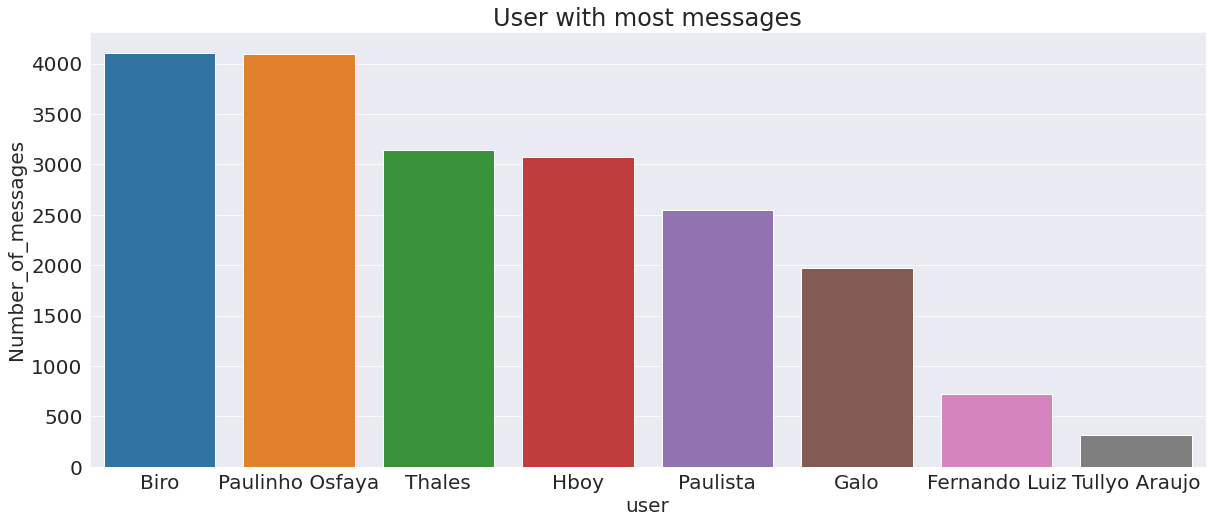

In [10]:
most_active_user(most_chat, "User with most messages")

# Question 3: Which emojis use the most in the group?

In [11]:
def get_emojis_list(df):
    emoji_counter = Counter()

    emoji_list = list(emoji.UNICODE_EMOJI_ENGLISH.keys())
    r = re.compile('|'.join(re.escape(p) for p in emoji_list))
                   
    for idx, row in df.iterrows():
        found = r.findall(row["message"])
        for emojif in found:
            emoji_counter[emojif] += 1
            
    return emoji_counter

In [12]:
def most_common_emojis(df, number):
    emoji_counter = get_emojis_list(df)
    emojis = emoji_counter.most_common(number)
    most_common = pd.DataFrame(emojis, columns=['emoji', 'count'])
    
    return most_common

In [13]:
emoji_df = df.copy()
most_emojis = most_common_emojis(emoji_df, 10) 
most_emojis

emoji  count
0     🤣    438
1     😂    245
2     👏    138
3     👀     86
4     🏼     78
5     😍     47
6     🏾     37
7     🤤     32
8     🙏     31
9     🏻     30

In [14]:
def emojis_pie_chart(most_emojis, title):
    fig = px.pie(most_emojis, values='count', names='emoji',title=title)
    fig.update_traces(textposition='inside', textinfo='percent+label')
    fig.show()

In [15]:
emojis_pie_chart(most_emojis, 'Emoji percentage used in chat group')

# Question 4: Which emoji is most used by each user?

In [16]:
#most emojis by user
users = emoji_df['user'].unique()

for user in users:
    subdf = emoji_df.loc[emoji_df['user']==user]
    most_emojis = most_common_emojis(subdf, 10)
    title = "Emoji percentage used in chat group by "+str(user)
    emojis_pie_chart(most_emojis, title)

# Question 5: What are the top words used in the conversation?

In [17]:
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('portuguese')

[nltk_data] Downloading package stopwords to /home/tullyo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [18]:
def most_words(df, title):
    word = " ".join(txt for txt in df.message)

    wordcloud = WordCloud(width = 800, height =800 ,stopwords=stopwords, background_color="black",min_font_size = 10).generate(word)

    plt.figure( figsize=(10,5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis("off")
    plt.show()

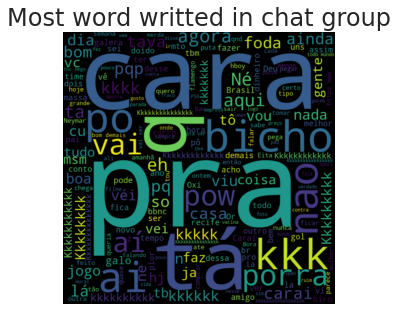

In [19]:
word_df = df.copy()
most_words(word_df, "Most word writted in chat group")

# Question 6: What are the top words used by each user?

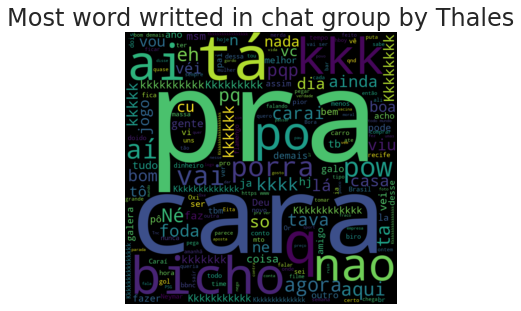

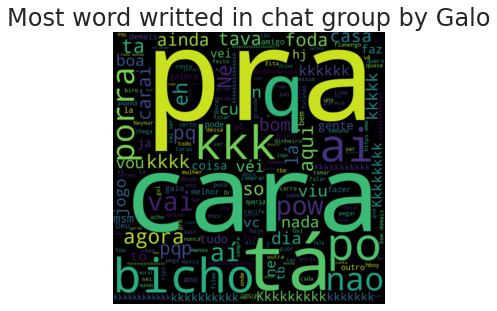

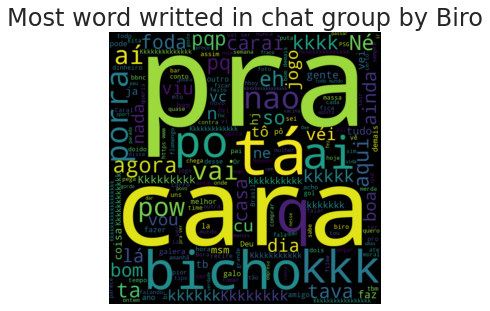

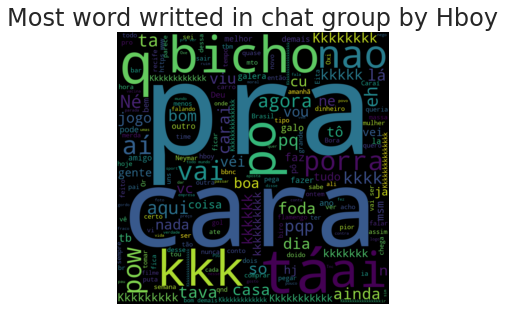

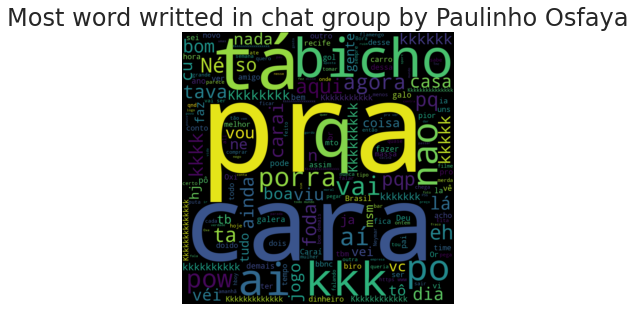

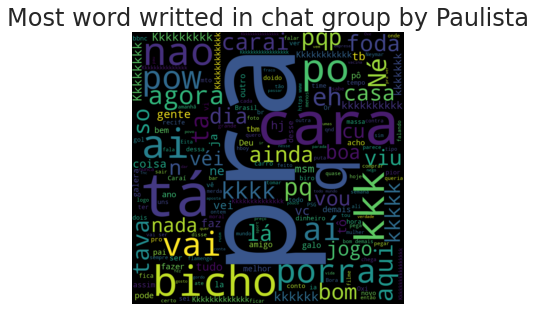

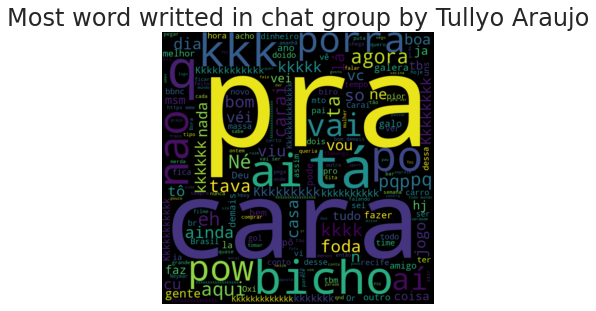

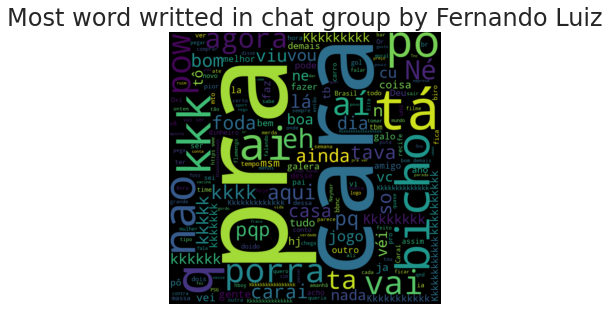

In [20]:
#most emojis by user
users = word_df['user'].unique()

for user in users:
    subdf = word_df.loc[word_df['user']==user]
    title = "Most word writted in chat group by "+str(user)
    most_words(word_df, title)

# Question 7: What is the most active time of messages in group throughout the day?


In [21]:
def most_active_hours(df, title): 
    matplotlib.rcParams['font.size'] = 20
    matplotlib.rcParams['figure.figsize'] = (20, 8)

    # Using the seaborn style 
    sns.set_style("darkgrid")
    plt.figure()

    plt.title(title);
    sns.barplot(x=df.Hour, y=df.Number_of_messages, data = df,dodge=False)


In [22]:
most_active = df.copy()
most_active['Hour'] = most_active['timestamp'].apply(lambda x: x.hour)
active = most_active['Hour'].value_counts().rename_axis('Hour').reset_index(name='Number_of_messages')
active

Hour  Number_of_messages
0     11                1655
1     16                1543
2     22                1515
3     23                1488
4      9                1410
5     21                1290
6     12                1263
7     10                1236
8     13                1112
9     14                1067
10    18                 994
11    19                 971
12    17                 967
13    20                 962
14    15                 808
15     8                 800
16     0                 501
17     7                 216
18     1                 138
19     6                  25
20     4                  11
21     5                   8
22     3                   2
23     2                   2

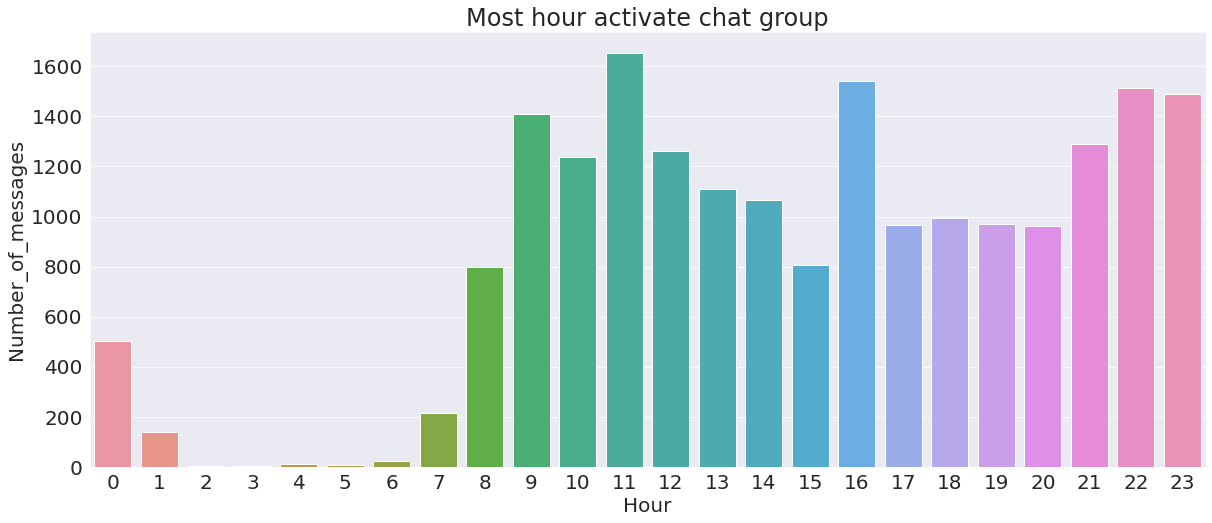

In [23]:
most_active_hours(active, "Most hour activate chat group")

# Question 8: What is the most active time for each user?

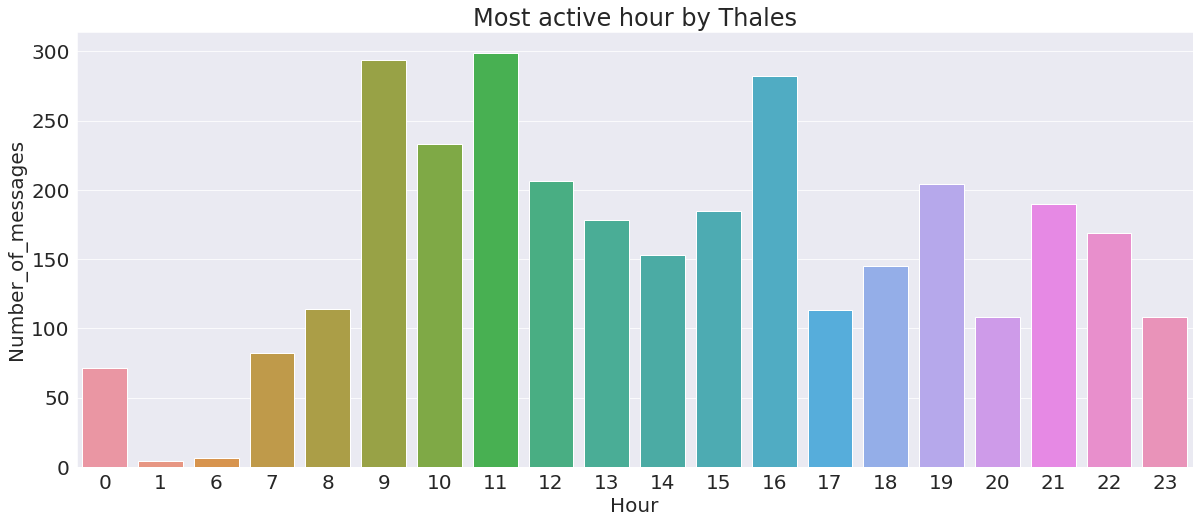

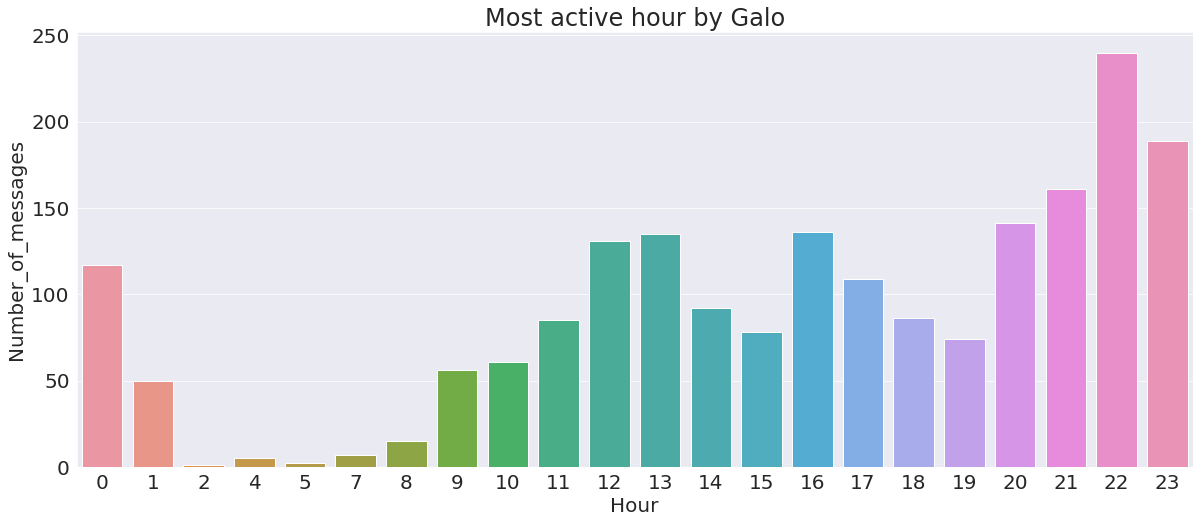

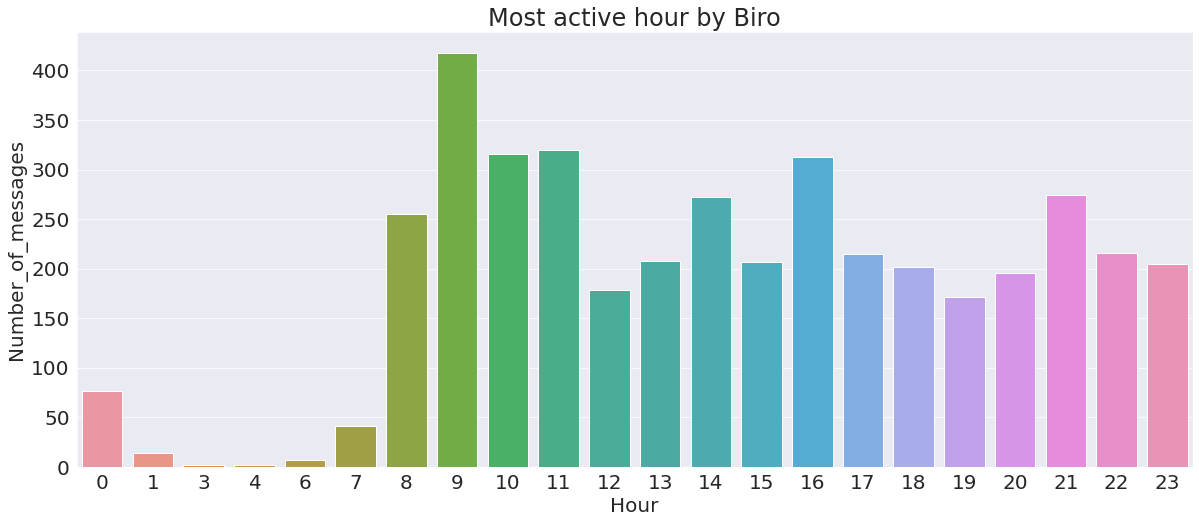

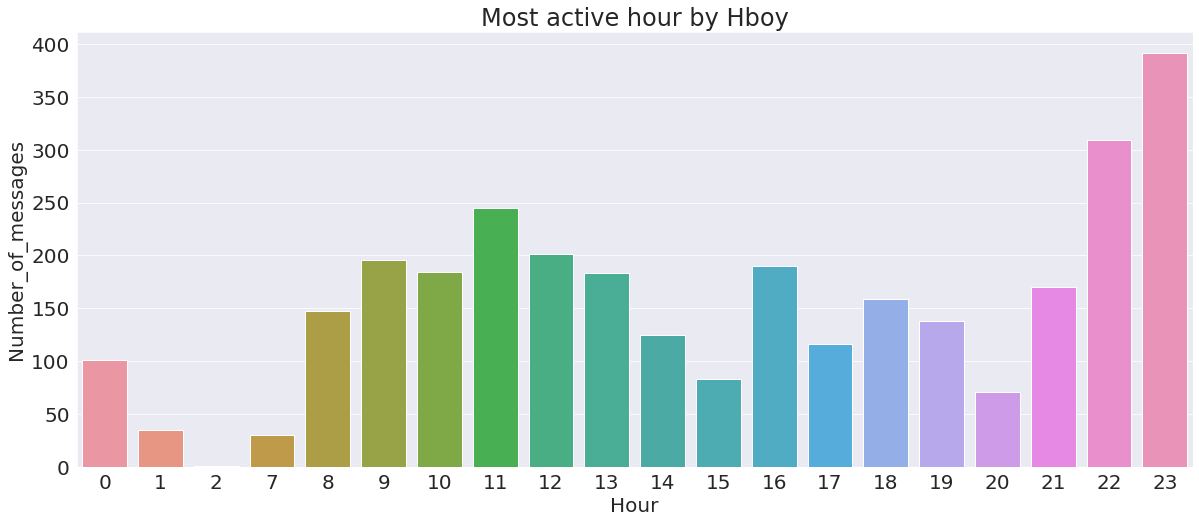

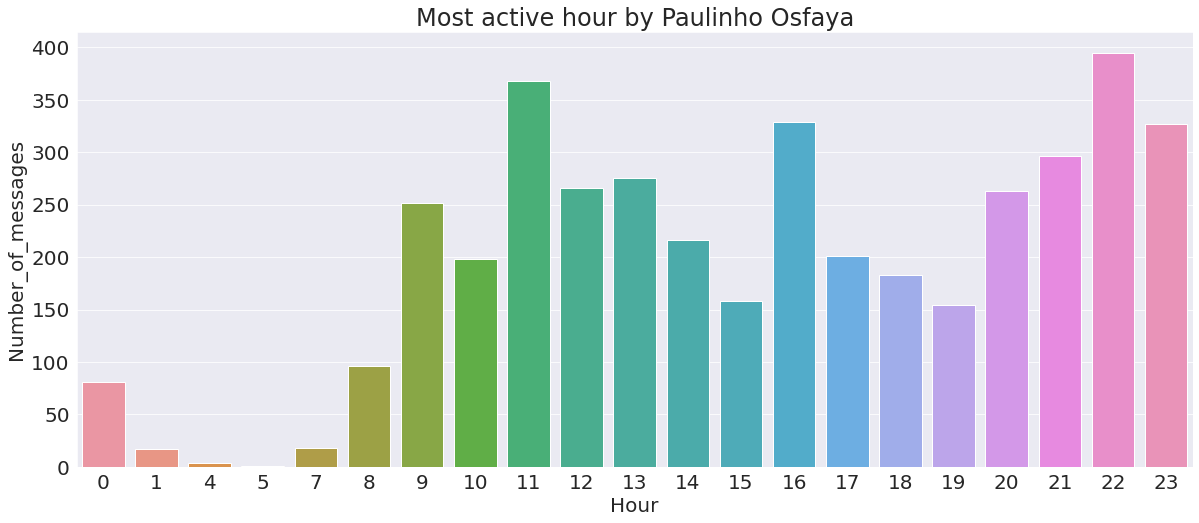

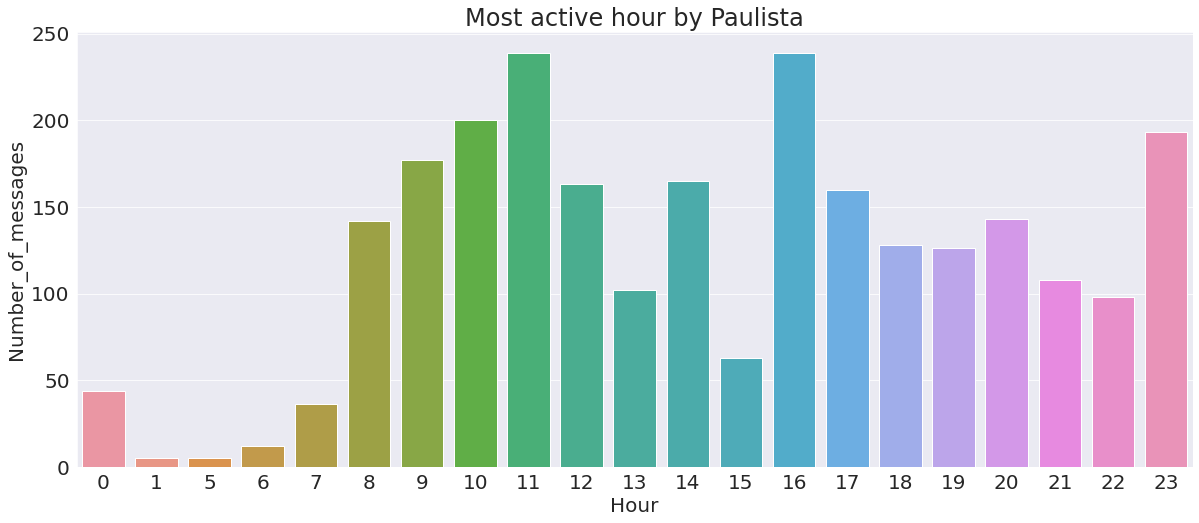

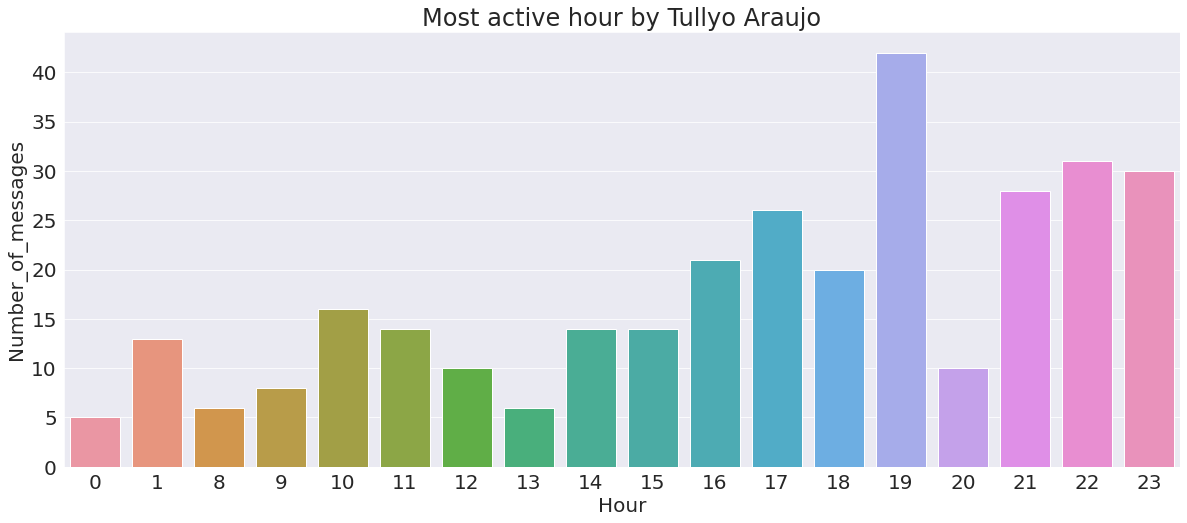

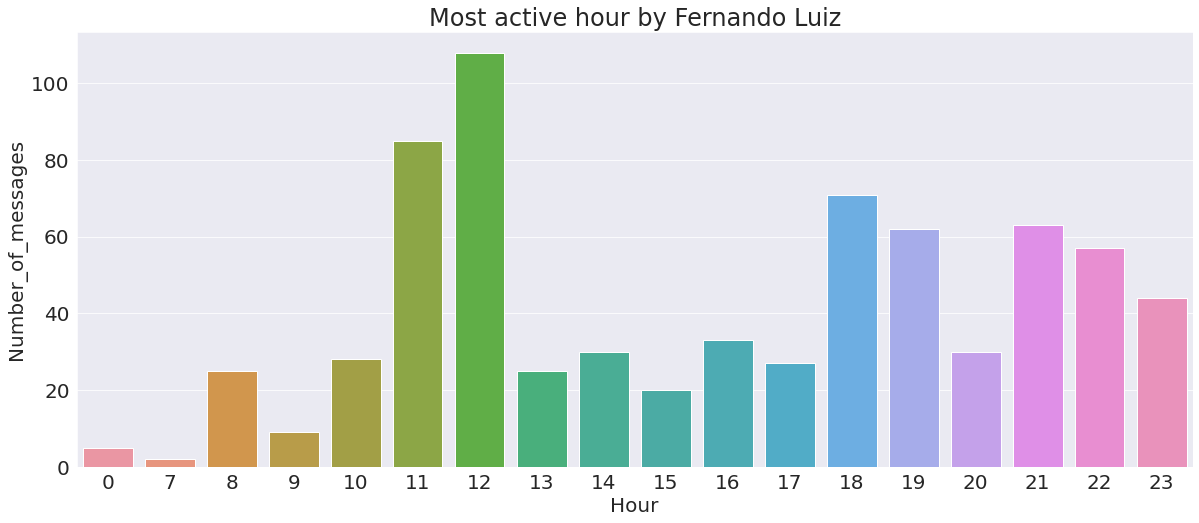

In [24]:
users = most_active['user'].unique()

for user in users:
    subdf = most_active.loc[most_active['user']==user]
    active = subdf['Hour'].value_counts().rename_axis('Hour').reset_index(name='Number_of_messages')
    title = "Most active hour by "+str(user)
    most_active_hours(active, title)

# Question 9: What is the most active day of messages in group throughout the week?

In [25]:
def most_active_day(df, title): 
    matplotlib.rcParams['font.size'] = 20
    matplotlib.rcParams['figure.figsize'] = (20, 8)

    # Using the seaborn style 
    sns.set_style("darkgrid")
    plt.figure()

    plt.title(title);
    sns.barplot(x=df.Day,y=df.Number_of_messages, data = df,dodge=False)

In [26]:
most_day = df.copy()
most_day['Day'] = most_active['timestamp'].apply(lambda x: x.day_name())
active = most_day['Day'].value_counts().rename_axis('Day').reset_index(name='Number_of_messages')
active

Day  Number_of_messages
0    Tuesday                3338
1     Friday                3285
2   Thursday                3162
3   Saturday                2830
4  Wednesday                2716
5     Sunday                2355
6     Monday                2298

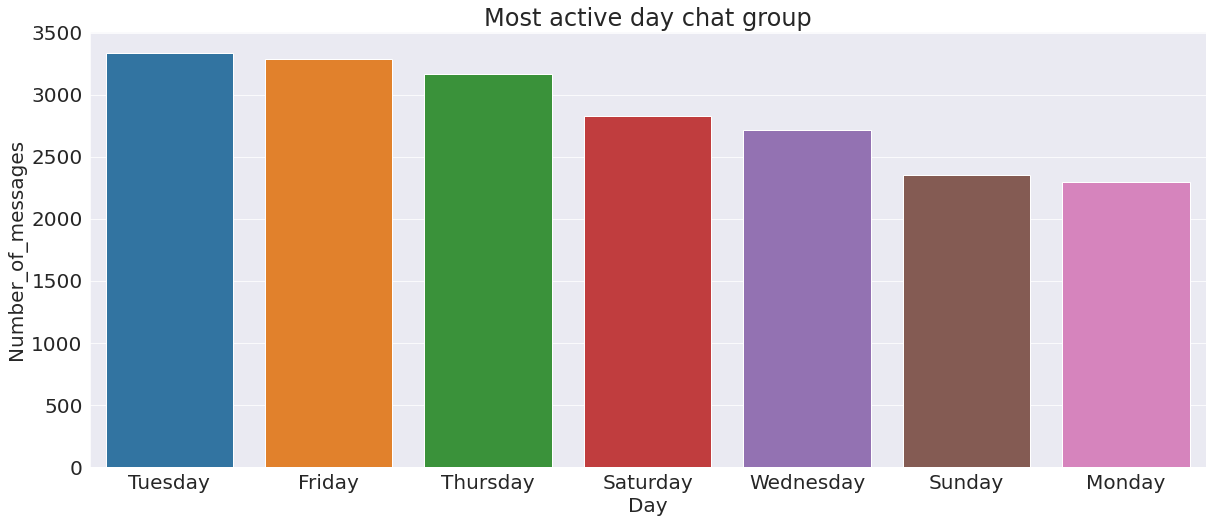

In [27]:
most_active_day(active, "Most active day chat group")

# Question 10: What is the most active day of each user in the group?

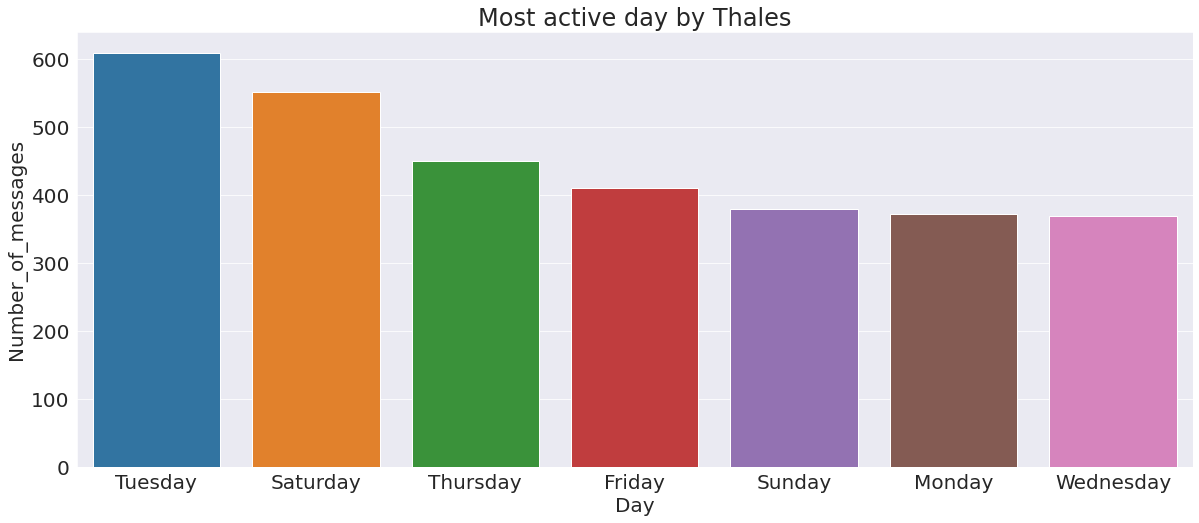

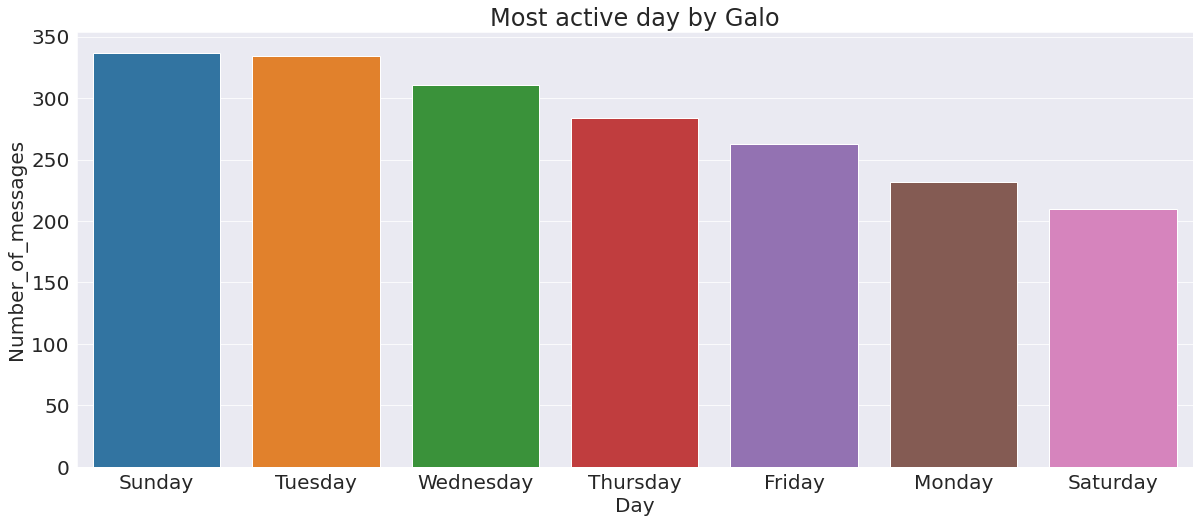

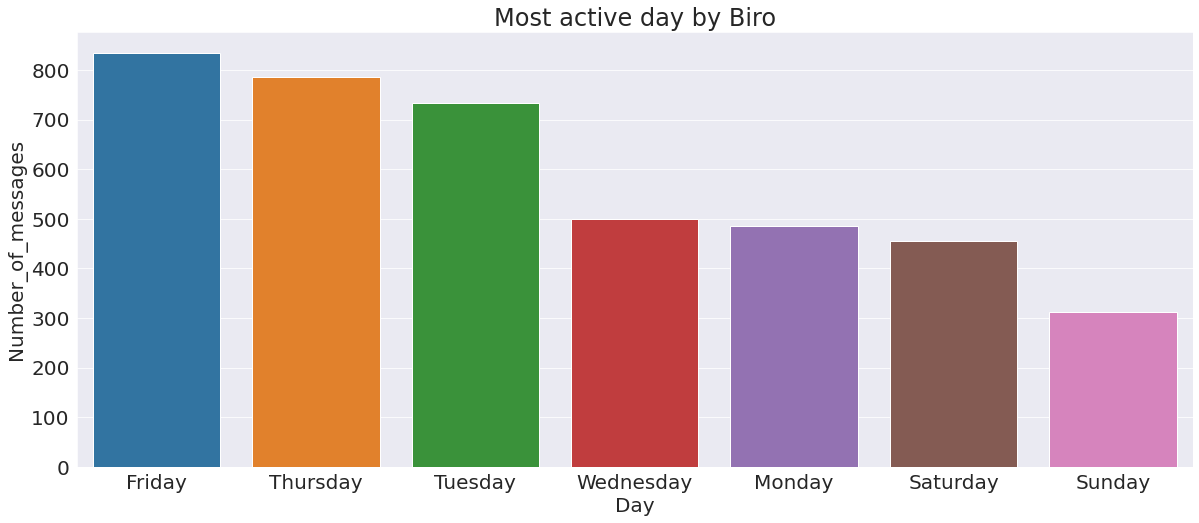

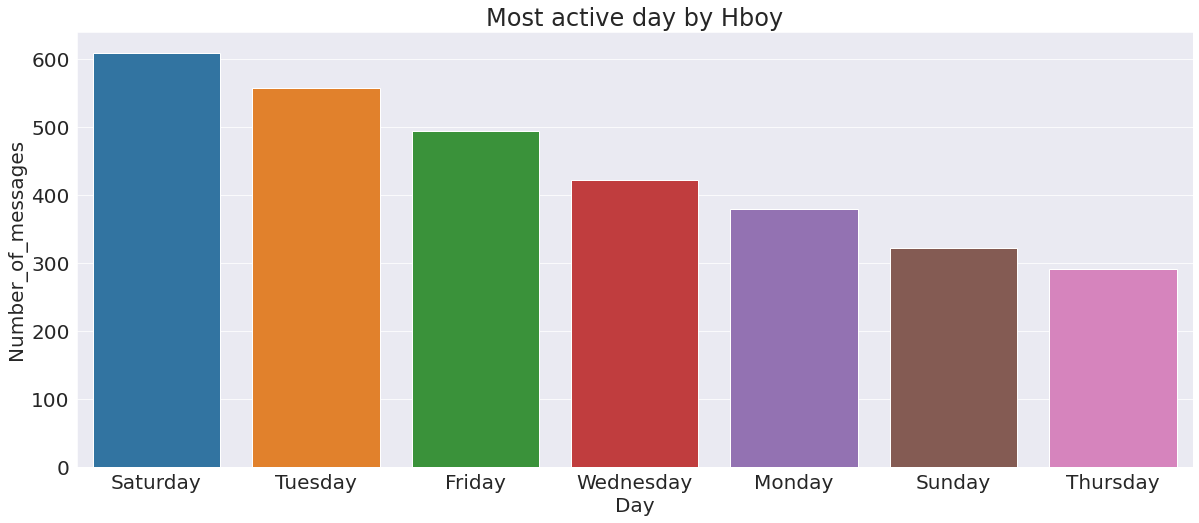

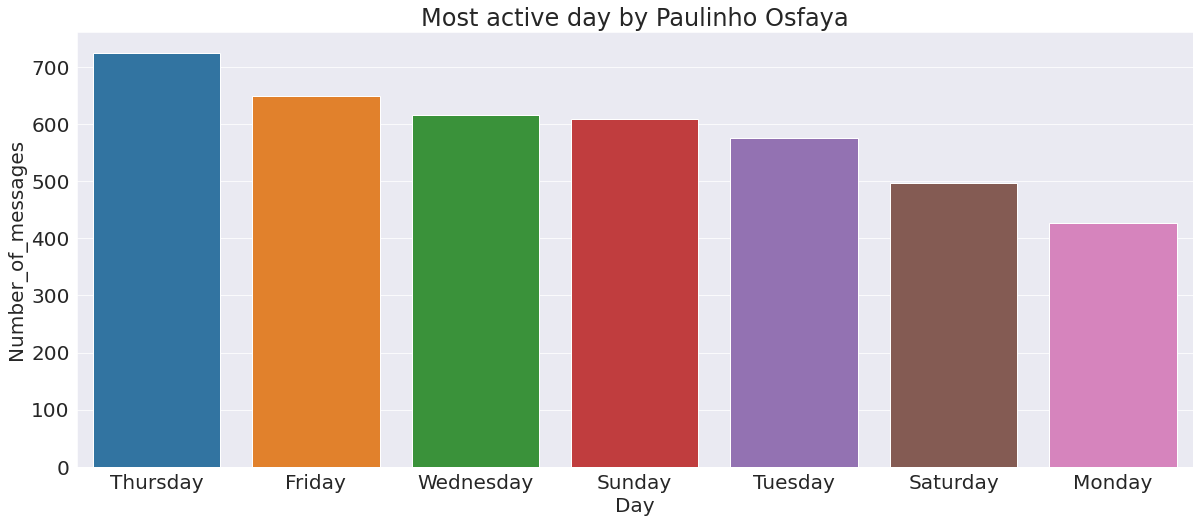

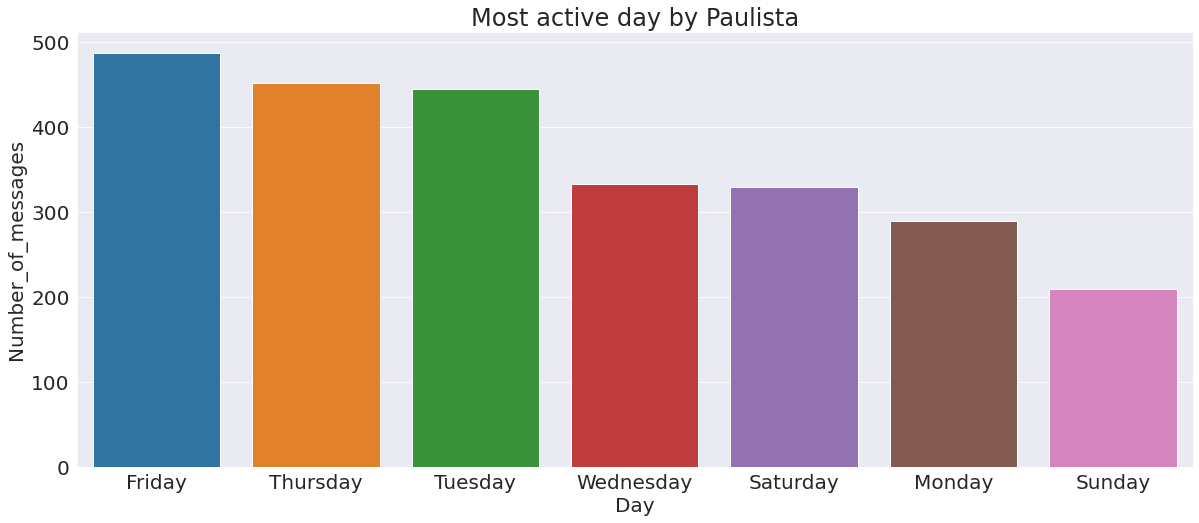

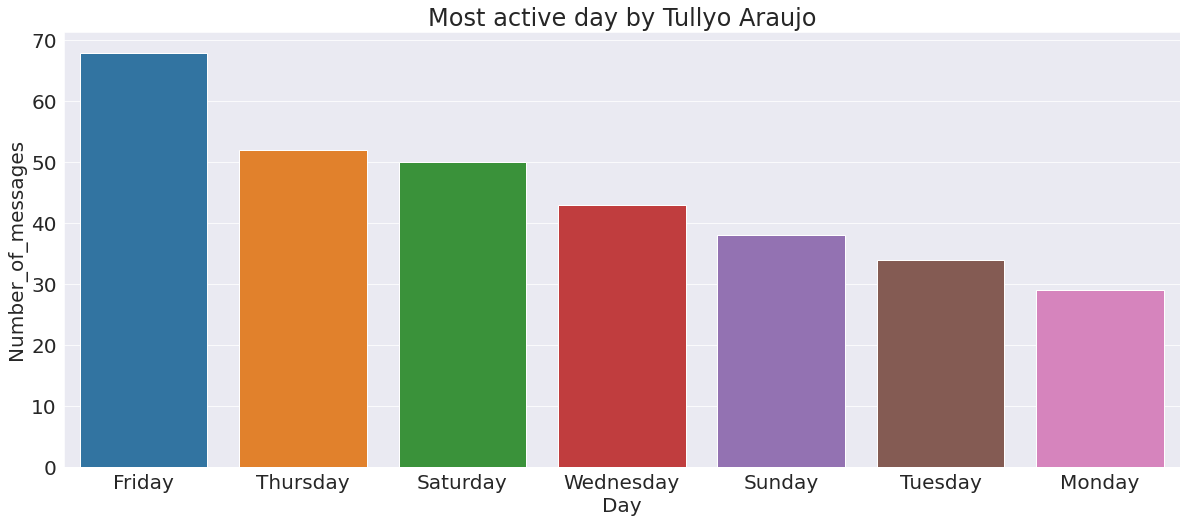

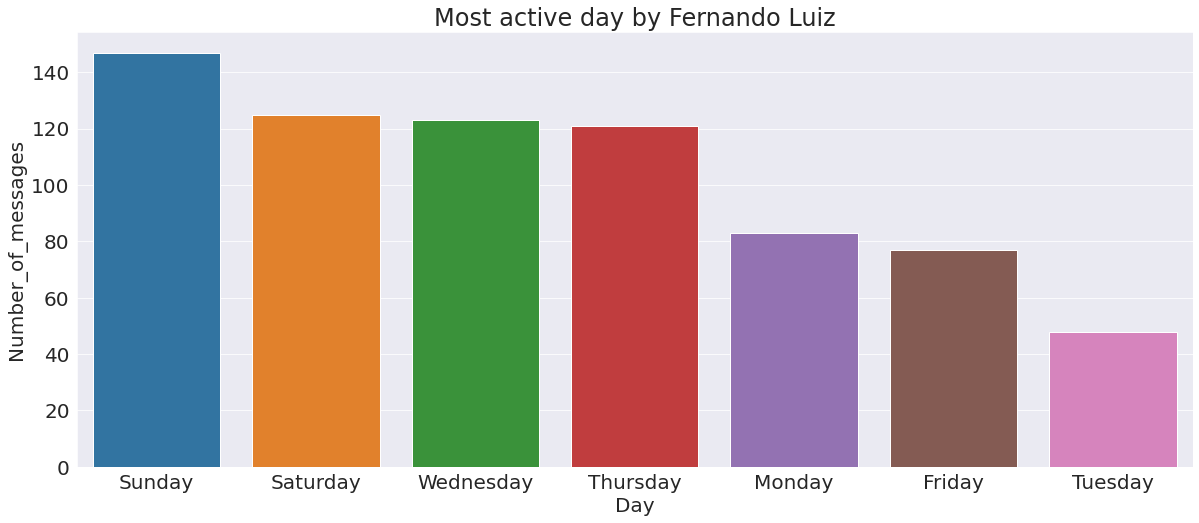

In [28]:
users = most_day['user'].unique()

for user in users:
    subdf = most_day.loc[most_day['user']==user]
    active = subdf['Day'].value_counts().rename_axis('Day').reset_index(name='Number_of_messages')
    title = "Most active day by "+str(user)
    most_active_day(active, title)

# Question 11: What is the most active month of messages in group?


In [29]:
def most_active_month(df, title): 
    matplotlib.rcParams['font.size'] = 20
    matplotlib.rcParams['figure.figsize'] = (20, 8)

    # Using the seaborn style 
    sns.set_style("darkgrid")
    plt.figure()

    plt.title(title);
    sns.barplot(x=df.Month,y=df.Number_of_messages, data = df,dodge=False)

In [30]:
most_month = df.copy()
most_month['Month'] = most_active['timestamp'].apply(lambda x: x.month_name())
active = most_month['Month'].value_counts().rename_axis('Month').reset_index(name='Number_of_messages')
active

Month  Number_of_messages
0   April                6788
1    July                4740
2   March                3851
3     May                3670
4    June                 681
5  August                 254

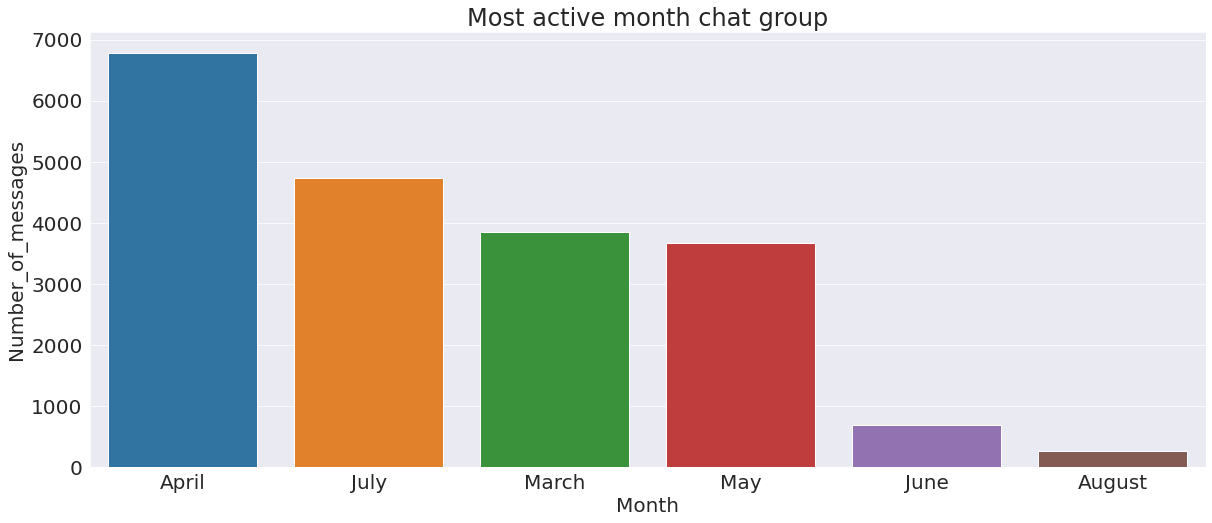

In [31]:
most_active_month(active, "Most active month chat group")

# Question 12: What is the most active month of each user in the group?

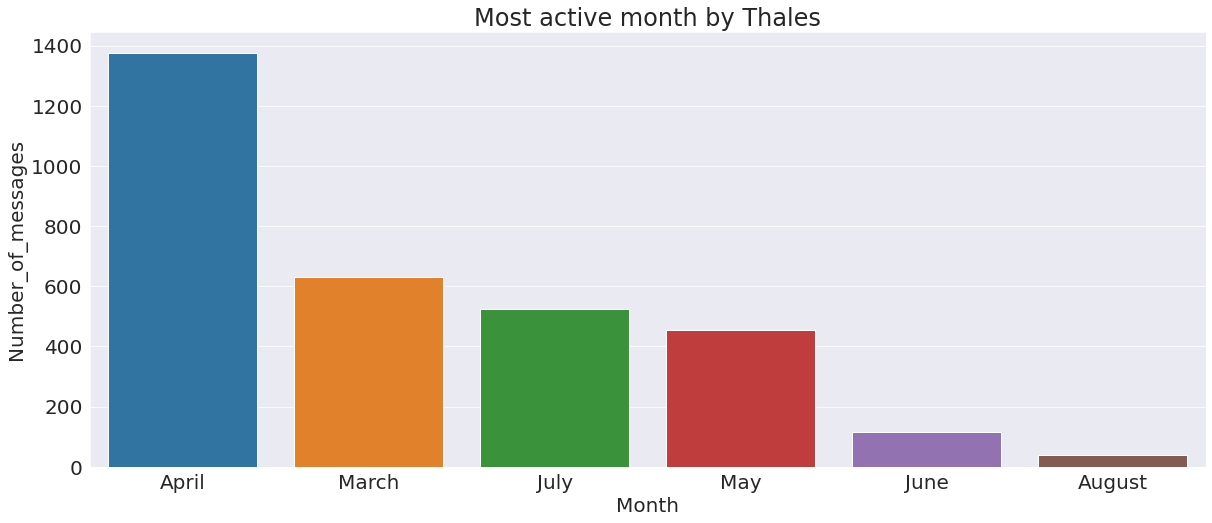

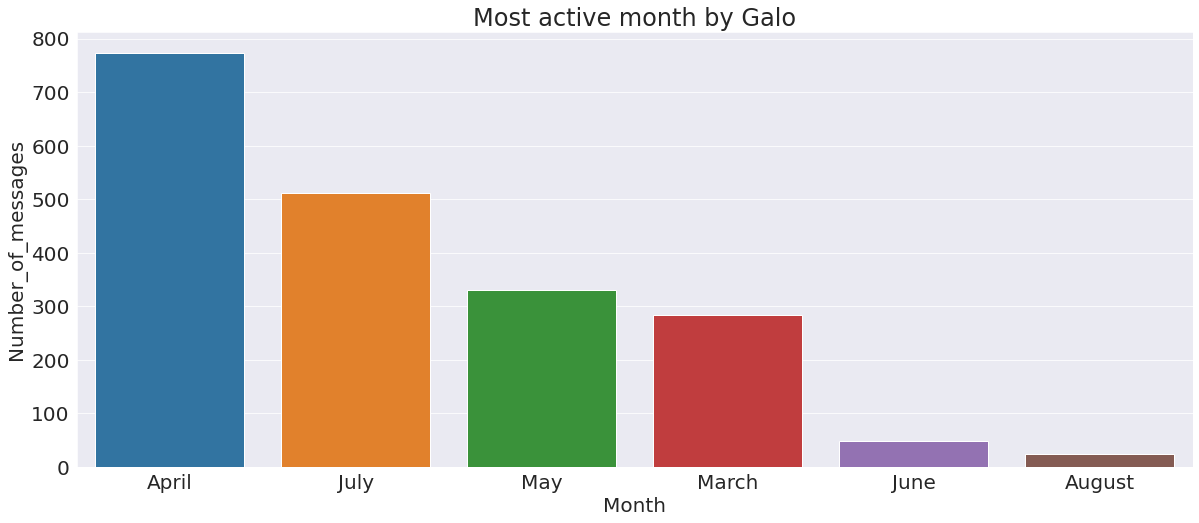

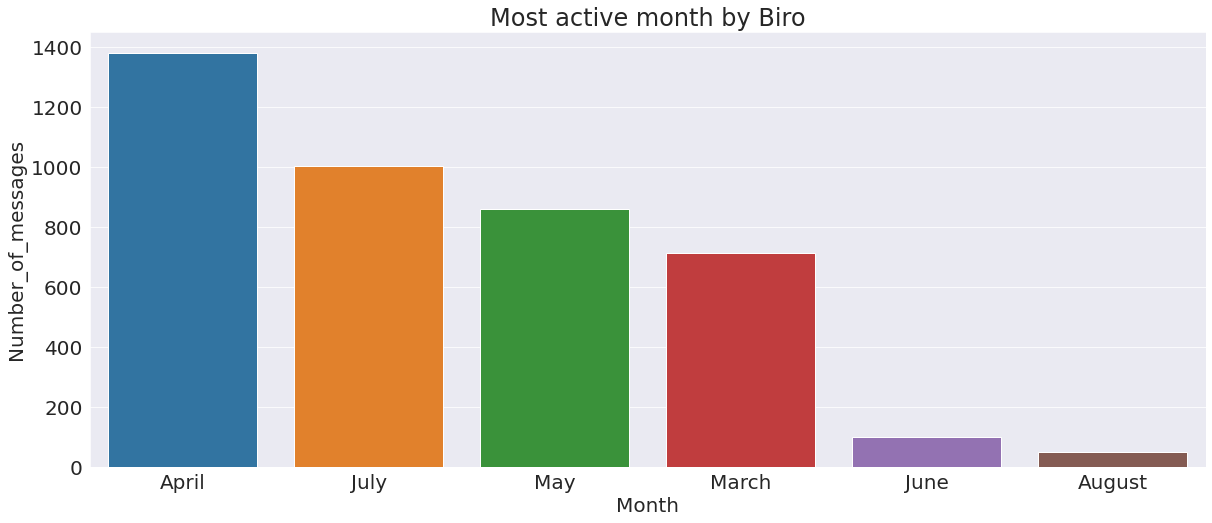

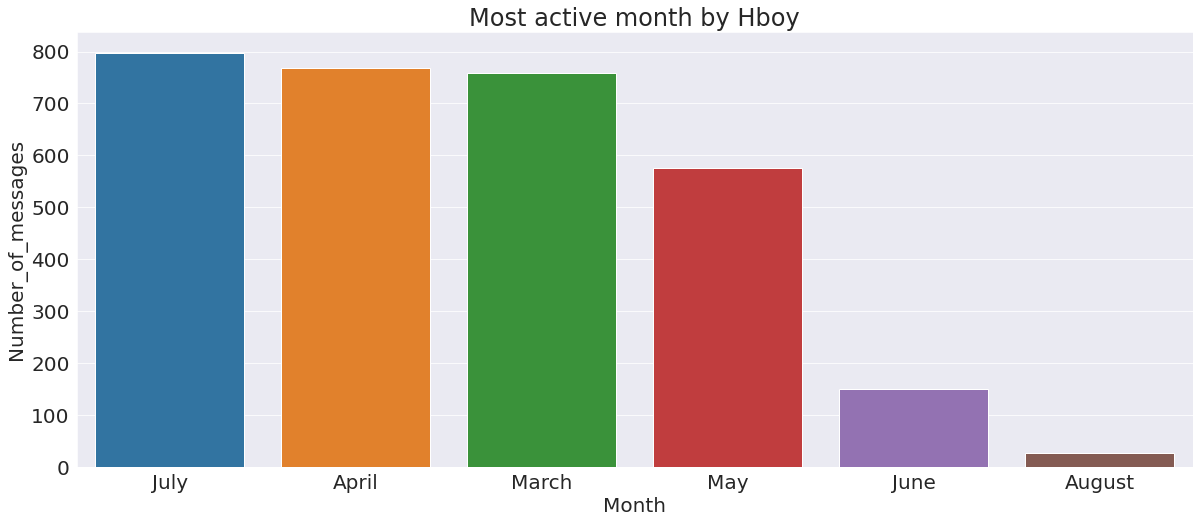

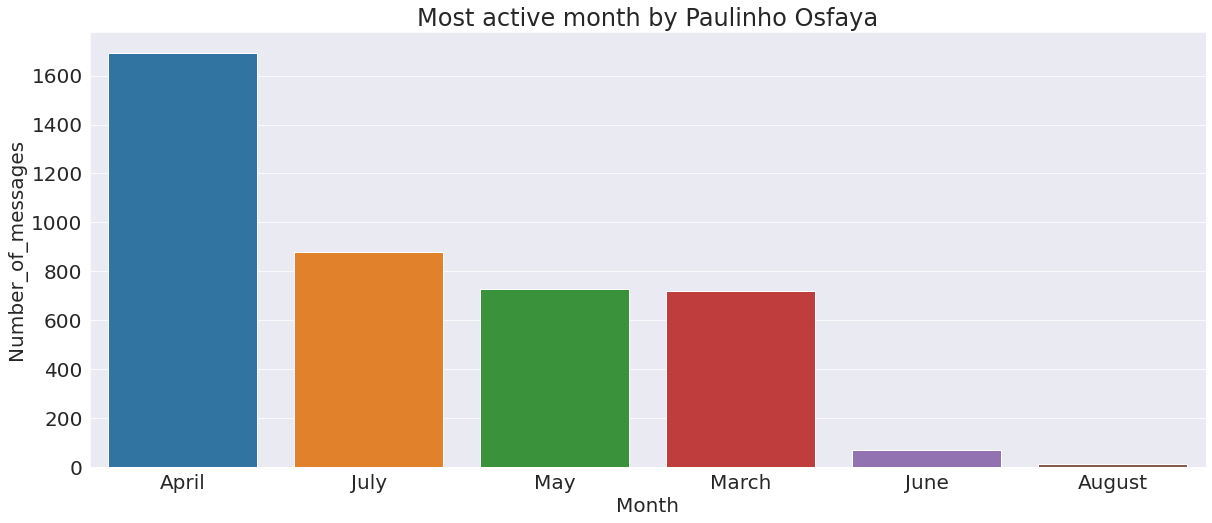

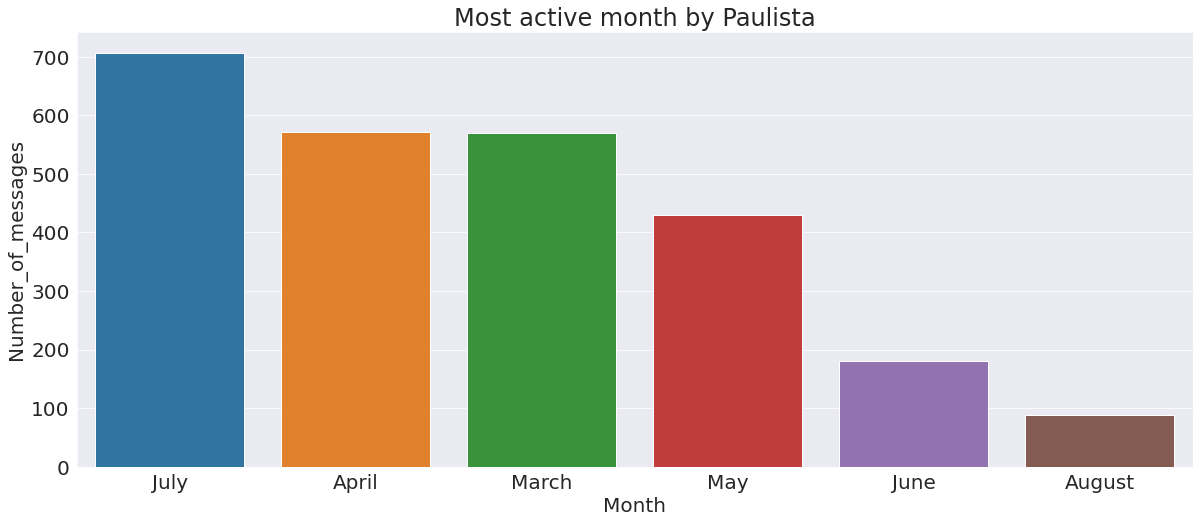

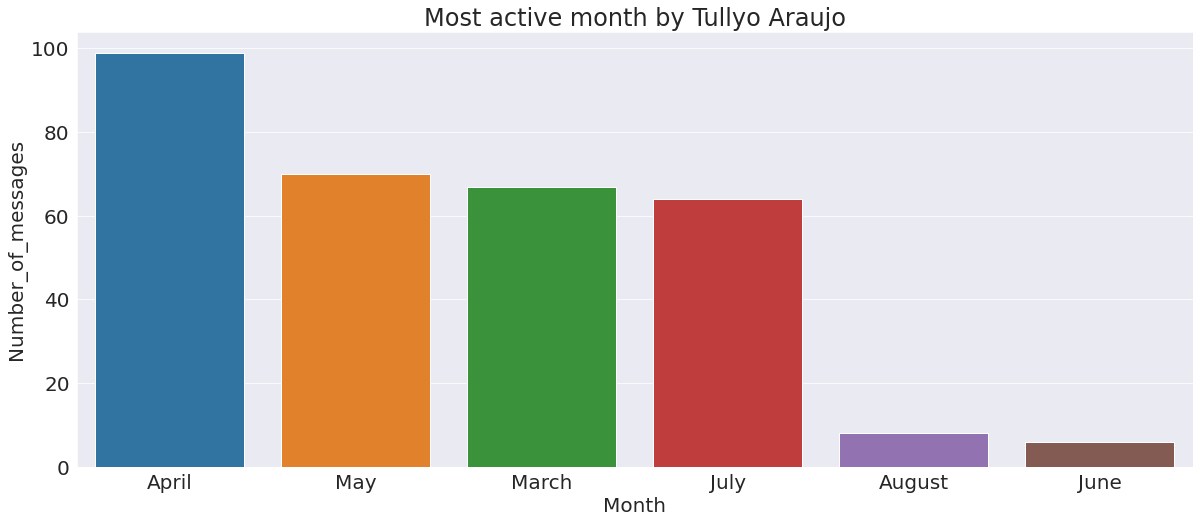

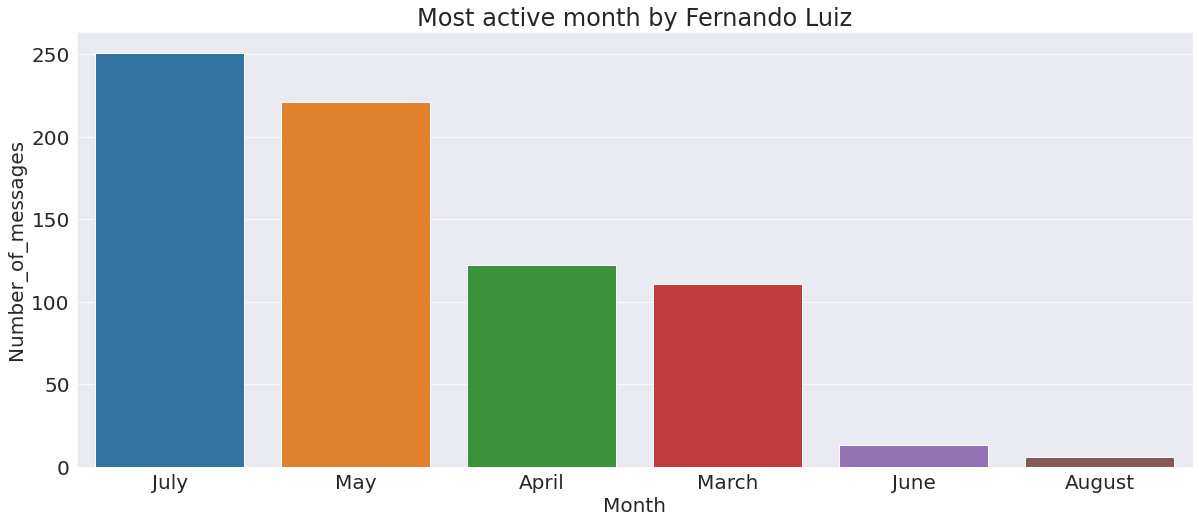

In [32]:
users = most_month['user'].unique()

for user in users:
    subdf = most_month.loc[most_day['user']==user]
    active = subdf['Month'].value_counts().rename_axis('Month').reset_index(name='Number_of_messages')
    title = "Most active month by "+str(user)
    most_active_month(active, title)